<a href="https://colab.research.google.com/github/makkimaki/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/main/Chapter6_Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前分布をどう決めるか？
- データセットのサイズ依存性
- 線形回帰における事前分布とペナルティの関係
慎重な選び方が時に必要。事前分布は個人的な信念を織り込めるが、**個人的信念を排除したい時**には慎重な選択が必要


- 客観的事前分布：基本的に、全区間、とりうるすべての値をもつものにする e.g.) 一様分布なら[0, 1]など
- 主観的事前分布(情報を含む事前分布, informative prior)

In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12
!pip install numpyro
!pip install 'pymc>=5.9'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=59e103ec04501318001cd774c01d80a7c580140c78b259b5f9caea1ee306fb88
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-mult

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az
import scipy
import scipy.stats as stats
from numpy.random import multinomial

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
print(f"{scipy.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.10.3'
sns.__version__='0.12.0'
np.__version__='1.23.5'
scipy.__version__='1.11.4'


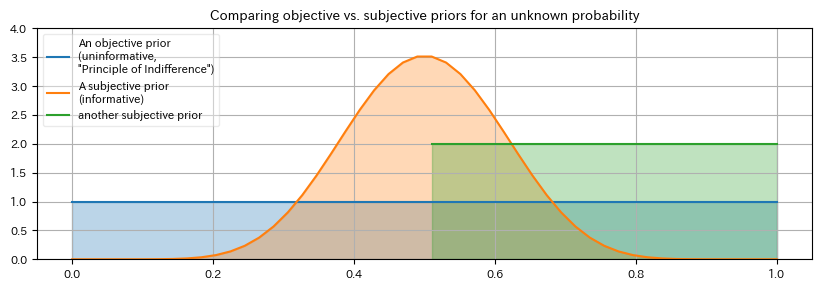

In [10]:
# 主観的(subjective)、客観的(objective)事前分布の例
plt.figure(figsize=(10, 3))
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0, 1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x, y2 ,label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

主観的事前分布というのは、ユーザーの主観的な意見を使うということとは必ずしも一致しない。
他の問題の事後分布が、この問題の事前分布になっているということが多い。

⇨つまり、事後分布の更新が行われている！

### 意思決定に次ぐ意思決定
- 科学的研究⇨客観的事前情報
- 医学的調査報告書
    - 信用に足るか？研究者の望む結果に資するような"**客観的**"事前分布を選んでいるかもしれない

- 客観的事前分布なら一様分布か？⇨そう単純じゃない
    - 未知数がとてつもなく大きい値を取るか？ないなら、使うべきじゃない

### 経験ベイズ（empirical Bayes）
頻度主義とベイズ推論を組み合わせるトリック
- ベイズ主義：$\alpha, \tau$といったハイパーパラメータを持つ
- 経験ベイズ：$\alpha, \tau$の選択には頻度主義の手法を使い、ベイズ推論する

（例） \\
$\sigma=5$の正規分布のパラメータ$\mu$を推定したい
- $\mu$の事前分布には正規分布を使える
- $(\mu_p, \sigma^2_p)$を決める

$\mu_p$の選び方
1. 経験ベイズ：**標本平均を使う、つまり観測データの平均**
1. 普通のベイズ：事前知識、客観的事前分布（平均0, 標準偏差大きめ）の何かを使う
※経験ベイズは、事前分布の設定に観測データ情報を用いるため、二重カウントしているといえる。真の不確実さが過小評価される恐れがある。よってデータ数が大きい場合に使う方が良さそう。

フローの違い

\begin{array}{|c|c|}
\hline
普通のベイズ & 事前分布 ⇨ 観測データ ⇨ 事後分布 \\
\hline
経験ベイズ & 観測データ ⇨ 事前分布 ⇨ 観測データ ⇨ 事後分布 \\
\hline
\end{array}

## ガンマ分布

## ウィシャート分布

## ベータ分布
$$
f_X(x|\alpha, \beta)=\frac{x^{(\alpha-1)}(1-x)^{(\beta-1)}}{B(\alpha, \beta)}
$$
- $\alpha, \beta = 1, 1$の場合、一様分布
- ベータ分布と二項分布の深い関係
    - 確率$p$を推定したいとして、$Beta(\alpha, \beta)$を$pP$の事前分布とする
    - $p$がデータ$X$~$Binomial(N, p)$を観測する
    - 事後分布は、$Beta(\alpha+X, \beta+N-X)$ \\
（例） $p$のprior: $Beta(1,1)$　(一様分布！)、観測データ$X$~$Binomial(N, p)$

⇨posterior: $Beta(\alpha+X, \beta+N-X)=Beta(1+10, 1+25-10), (N=25, X=10, 25回中10回成功した)$

## ベイズ多腕バンディット
- 10台のスロットマシン
- アームをひいて当たりが出る確率は、バンディット（スロットマシン）によって異なる
- その確率はもちろん不明
- **自分の勝ち分を最大化する戦略は？**=「最も良いバンディットがどれなのかをできるだけ早く見抜く」
    - 最良のバンディットでなくても、偶然多く当たるkともある⇨最良バンディットだと信じてしまう
    - 逆もあるはず
    - このまま負け続けるべきか、諦めて他を当たるか？
    - 「探索と利用のジレンマ」：いいバンディットを見つけて、そのまま引き続けるか、もっと良いものがあるかトライするか？

### 応用
- ネット広告  
広告パターンの運用方法で売上を最大化したい
- 生物学  
限られたエネルギーで有益な行動を最適化する、最大化する
- 金融  
どのストックオプションのリターンが高いか？
- 臨床試験  

ベイズバンディット：https://sites.socsci.uci.edu/~ivan/asmb.874.pdf

### 解法
- 事前情報なしからスタート
- システムをテストしながらデータ収集
- データと結果を収集しながら最良の行動を学習する

 **ベイズバンディット**
- 各バンディットで勝つ確率の事前分布を仮定することからスタート
1. 各バンディット$b$のpriorから結果$X_b$をランダムランプリング：今回の例題では一様分布を使用
1. 最良のサンプルを出したバンディット$B$を選択　i.e.) $B=$argmax$X_b$
1. バンディット$B$の結果を観測し、バンディット$B$のpriorを更新
1. 1に戻る

$N$個の分布（バンディット$B$の個数？）からのサンプリング  
- 事前分布は[0,1]の一様分布(=$Beta(\alpha=1, \beta=1)$)
- 観測結果は二値。  
⇨事後分布: $Beta(\alpha=1+X, \beta=1+1-X)$










